In [1]:
import pandas as pd

parsed = pd.read_csv("output/parsed_results.csv")
dep_summary = pd.read_csv("output/dependency_summary.csv")
proj_summary = pd.read_csv("output/project_summary.csv")

parsed.head(), dep_summary.head(), proj_summary.head()


(        project dependency dependency_version  direct_dependency  \
 0  aimhubio_aim    mistune              0.8.4               True   
 1  aimhubio_aim     sphinx                NaN               True   
 2  aimhubio_aim     sphinx                NaN               True   
 3  aimhubio_aim     sphinx                NaN               True   
 4  aimhubio_aim     sphinx                NaN               True   
 
            cve_id    cwe_id release_date  \
 0  CVE-2022-34749  CWE-1333   2022-07-05   
 1  CVE-2020-11022    CWE-79   2020-04-29   
 2  CVE-2020-11023    CWE-79   2020-04-13   
 3             NaN  CWE-1333   2023-08-01   
 4             NaN  CWE-1333   2023-08-01   
 
                                          description  security_level_id  \
 0  mistune是Hsiaoming Yang个人开发者的一个快速而强大的 Python Ma...                  2   
 1  jQuery是美国John Resig个人开发者的一套开源、跨浏览器的JavaScript库...                  3   
 2  jQuery是美国John Resig个人开发者的一套开源、跨浏览器的JavaScript库...                  3   
 3  ## O

In [2]:
dep_summary_sorted = dep_summary.sort_values("projects", ascending=False)
dep_summary_sorted.head(20)


,dependency,projects,total_cves,rows
212,requests,18,5,149
59,cryptography,14,29,314
129,lxml,12,6,78
233,sphinx,11,2,24
261,urllib3,9,12,118
10,Pillow,8,51,539
112,jinja2,7,10,91
204,pyyaml,7,3,24
55,cookie,7,1,10
186,psutil,6,1,7


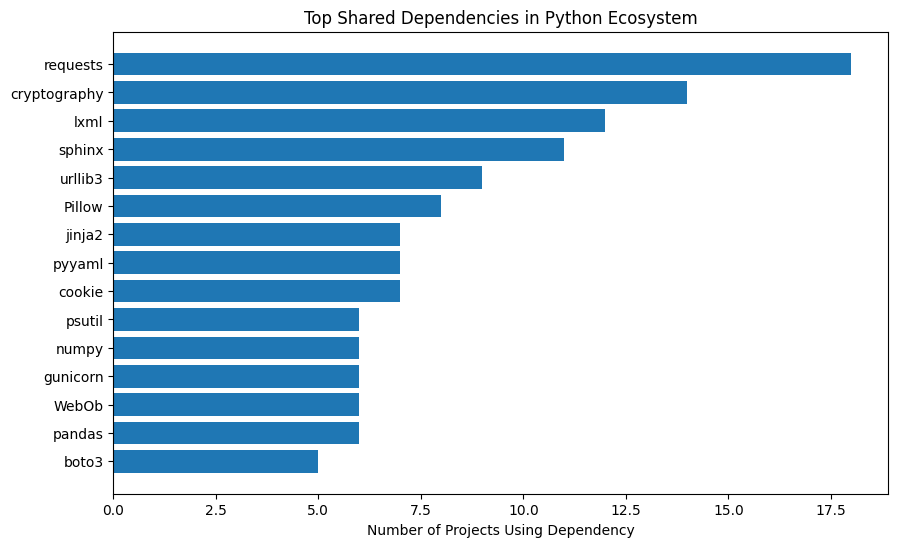

In [3]:
import matplotlib.pyplot as plt

top = dep_summary_sorted.head(15)
plt.figure(figsize=(10,6))
plt.barh(top["dependency"], top["projects"])
plt.xlabel("Number of Projects Using Dependency")
plt.title("Top Shared Dependencies in Python Ecosystem")
plt.gca().invert_yaxis()
plt.show()


In [4]:
dep_impact = dep_summary.assign(
    propagation_factor = dep_summary["projects"] * dep_summary["total_cves"]
).sort_values("propagation_factor", ascending=False)

dep_impact.head(20)


,dependency,projects,total_cves,rows,propagation_factor
241,tensorflow,4,152,532,608
10,Pillow,8,51,539,408
59,cryptography,14,29,314,406
170,pillow,5,51,298,255
261,urllib3,9,12,118,108
139,mlflow,2,53,304,106
246,torch,4,26,622,104
212,requests,18,5,149,90
88,gradio,2,44,155,88
119,langchain,4,21,51,84


In [5]:
proj_risk = proj_summary.sort_values("total_cves", ascending=False)
proj_risk.head(20)


,project,vulnerable_dependencies,total_cves,rows
12,gradio-app_gradio,35,401,2126
16,mindsdb_mindsdb,29,293,346
3,aimhubio_aim,56,289,378
18,mlflow_mlflow,58,284,579
0,Checkmk_checkmk,56,197,270
21,odoo_odoo,22,131,193
4,ajenti_ajenti,41,107,144
9,freeipa_freeipa,11,87,144
2,StackStorm_st2,31,85,272
1,GaiZhenbiao_ChuanhuChatGPT,16,83,83


In [6]:
cve_spread = parsed.groupby("cve_id")["project"].nunique().reset_index()
cve_spread = cve_spread.sort_values("project", ascending=False)
cve_spread.head(10)

,cve_id,project
643,CVE-2024-35195,18
709,CVE-2024-47081,18
428,CVE-2023-2650,14
515,CVE-2023-50782,14
466,CVE-2023-38325,14
405,CVE-2023-0216,13
397,CVE-2022-4203,13
406,CVE-2023-0217,13
408,CVE-2023-0401,13
282,CVE-2021-43818,12


In [7]:
parsed["cwe_id"].value_counts().head(15)

cwe_id
CWE-20      343
CWE-502     325
CWE-400     322
CWE-125     313
CWE-1333    312
CWE-119     263
CWE-476     229
CWE-22      194
CWE-79      175
CWE-120     133
CWE-787     113
CWE-200     113
CWE-770     109
CWE-94      105
CWE-190     102
Name: count, dtype: int64

<Axes: xlabel='year'>

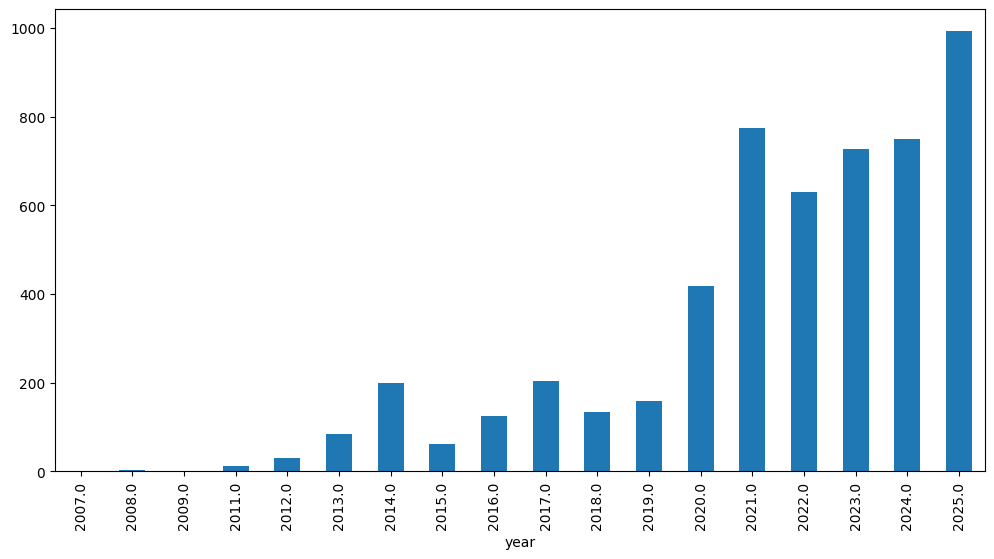

In [8]:
parsed["year"] = pd.to_datetime(parsed["release_date"], errors="coerce").dt.year
parsed["year"].value_counts().sort_index().plot(kind="bar", figsize=(12,6))

In [11]:
import networkx as nx
G = nx.Graph()

for _, row in parsed.iterrows():
    project = row["project"]
    dep = row["dependency"]

    G.add_node(project, type="project")
    G.add_node(dep, type="dependency")

    G.add_edge(project, dep)
    
nx.write_gexf(G, "python_ecosystem_graph.gexf")


In [ ]:
import pandas as pd

df = pd.read_csv("output/parsed_results.csv")
df["project"].unique()
len(df["project"].unique())

43

In [12]:
parsed.groupby("cve_id")["project"].nunique()


cve_id
CVE-2007-0240    1
CVE-2008-0299    2
CVE-2009-0662    1
CVE-2009-5065    2
CVE-2011-1156    2
                ..
CVE-2025-8747    2
CVE-2025-8869    2
CVE-2025-9287    1
CVE-2025-9905    2
CVE-2025-9906    2
Name: project, Length: 906, dtype: int64

In [13]:
parsed["cwe_id"].value_counts()

cwe_id
CWE-20             343
CWE-502            325
CWE-400            322
CWE-125            313
CWE-1333           312
                  ... 
CWE-237              1
CWE-683              1
CWE-592              1
CWE-601 CWE-79       1
CWE-130 CWE-120      1
Name: count, Length: 239, dtype: int64

In [14]:
parsed["year"].value_counts().sort_index()


year
2007.0      1
2008.0      3
2009.0      1
2011.0     11
2012.0     31
2013.0     85
2014.0    200
2015.0     62
2016.0    126
2017.0    203
2018.0    135
2019.0    159
2020.0    418
2021.0    776
2022.0    630
2023.0    727
2024.0    750
2025.0    993
Name: count, dtype: int64

In [ ]:
proj_summary.sort_values("total_cves", ascending=False)

,project,vulnerable_dependencies,total_cves,rows
12,gradio-app_gradio,35,401,2126
16,mindsdb_mindsdb,29,293,346
3,aimhubio_aim,56,289,378
18,mlflow_mlflow,58,284,579
0,Checkmk_checkmk,56,197,270
21,odoo_odoo,22,131,193
4,ajenti_ajenti,41,107,144
9,freeipa_freeipa,11,87,144
2,StackStorm_st2,31,85,272
1,GaiZhenbiao_ChuanhuChatGPT,16,83,83
